<a href="https://colab.research.google.com/github/lwerth/INFO510-public/blob/master/INFO410_hwk4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Analysis of radon measurements:

(a) Fit a linear regression to the logarithms of the radon measurements in Table 7.3, with indicator variables for the three counties and for whether a measurement was recorded on the first floor. Summarize your posterior inferences in nontechnical terms.


In [49]:
pip install pymc3 --upgrade

     |████████████████████████████████| 1.9MB 2.7MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=43f01d20d81cdb1843d811a803919f9c49e2bc8ba720b4598ac7bb3e6ec7ed01
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [1]:
#using wine notebook for help
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm
from scipy import stats
import seaborn as sb
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import arviz

%matplotlib inline
import matplotlib.pyplot as plt

import theano

In [41]:
radon = pd.read_csv('/content/drive/My Drive/Fall 2020/info410/hwk4/radon.csv')
radon.head(10)

,county,radon,floor
0,Blue Earth,5.0,0
1,Blue Earth,13.0,0
2,Blue Earth,7.2,0
3,Blue Earth,6.8,0
4,Blue Earth,12.8,0
5,Blue Earth,5.8,1
6,Blue Earth,9.5,0
7,Blue Earth,6.0,0
8,Blue Earth,3.8,0
9,Blue Earth,14.3,1


In [44]:
#transform the data

#standardize the data with log
# radon['radon'] = radon['radon'].astype(theano.config.floatX)
county_names = radon.county.unique()
county_idx = OrdinalEncoder(dtype = np.int64).fit_transform(radon[['county']])

# n_counties = len(radon.county.unique())


#encode county as int for ordinal data
# radon[['county']] = OrdinalEncoder(dtype = np.int64).fit_transform(radon[['county']])

# #encode radon into a standard scalar
radon[['radon']] = StandardScaler().fit_transform(radon[['radon']])
# radon.log_radon = np.log(radon)

n_counties = len(radon.county.unique())
radon

,county,radon,floor
0,Blue Earth,-0.465669,0
1,Blue Earth,0.594285,0
2,Blue Earth,-0.174182,0
3,Blue Earth,-0.227179,0
4,Blue Earth,0.567787,0
5,Blue Earth,-0.359674,1
6,Blue Earth,0.130555,0
7,Blue Earth,-0.333175,0
8,Blue Earth,-0.624662,0
9,Blue Earth,0.766528,1


In [46]:
#LIke the wine notebook example, sample the effects of the county and basement

with pm.Model() as wj_model:
  #add parameter priors
  cnty = pm.Normal('cnty', 0, .5, shape = 3)
  bsmt = pm.Normal('bsmt', 0, .5, shape = 2)

  alpha = pm.Normal('alpha', 0, .2)
  sigma = pm.Exponential('sigma', 1)
  
  mu = alpha + cnty[radon.county.values] + bsmt[radon.floor.values]
  score = pm.Normal('score', mu = mu, sigma = sigma, observed = radon['radon'])

  cb_trace = pm.sample(2000, target_accept = .95)
  cb_sumtab = pm.summary(cb_trace)


RecursionError: ignored

Unpooled/non-hierarchical model
>maybe for 14.1 b) ????

In [32]:
#unpooled non-hierarchical

with pm.Model() as unpooled_model:

    # Independent parameters for each county
    a = pm.Normal('a', 0, sd=100, shape=n_counties)
    b = pm.Normal('b', 0, sd=100, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx]*radon.floor.values

    # Data likelihood
    y = pm.Normal('y', radon_est, sd=eps, observed=radon.radon)

In [33]:
with unpooled_model:
    unpooled_trace = pm.sample(5000)    
    unpooled_sum = pm.summary(unpooled_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 15 seconds.


In [35]:
pm.forestplot(unpooled_trace, var_names = unpooled_trace.varnames.remove('eps'))

ValueError: ignored

Hierarchical model
> 14.1 a)

In [36]:
#set mu and sd to a fixed value

with pm.Model() as radonH_mod:
  mu_a = pm.Normal('mu_a', mu = 0, sd = 1000**2) #set mu and sd to a fixed value
  sigma_a = pm.HalfCauchy('sigma_a', 5)
  mu_b = pm.Normal('mu_b', mu=0, sd=1000**2)
  sigma_b = pm.HalfCauchy('sigma_b', 5)

  # Intercept for each county, distributed around group mean mu_a
  # plug in a common group distribution for all a and b (which are
   # vectors of length n_counties).

  a = pm.Normal('a', mu = mu_a, sd = sigma_a, shape = n_counties)
  b = pm.Normal('b', mu = mu_b, sd = sigma_b, shape = n_counties)
  
      
  eps = pm.HalfCauchy('eps', 5) #model error (epsilon)
  
  radon_eps = a[county_idx] + b[county_idx] * radon.floor.values
  
  #data likelihood
  radon_likelihood = pm.Normal('radon_likelihood', mu=radon_eps, sd = eps, observed = radon.radon)



In [37]:
with radonH_mod:
  hierarchical_trace = pm.sample(draws=2000, n_init=1000)
  hierarchical_sumry = pm.summary(hierarchical_trace)
  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 21 seconds.
There were 535 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6017536045201989, but should be close to 0.8. Try to increase the number of tuning steps.
There were 907 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6836686869137862, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [38]:
# pm.forestplot(hierarchical_trace, var_names = hierarchical_trace.varnames.remove('eps'))

hierarchical_sumry

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,9.033,0.793,7.952,10.420,0.040,0.029,398.0,364.0,288.0,657.0,1.02
mu_b,-2.601,1.311,-4.869,-0.541,0.144,0.124,83.0,56.0,35.0,97.0,1.07
a[0],9.029,0.287,8.417,9.552,0.018,0.013,262.0,262.0,295.0,99.0,1.05
a[1],9.033,0.302,8.352,9.543,0.025,0.017,150.0,150.0,142.0,132.0,1.02
a[2],9.030,0.301,8.355,9.544,0.019,0.014,248.0,248.0,260.0,109.0,1.01
b[0],-2.654,0.686,-3.758,-1.298,0.133,0.095,26.0,26.0,31.0,218.0,1.06
b[1],-2.667,0.674,-3.824,-1.475,0.133,0.095,26.0,26.0,32.0,136.0,1.06
b[2],-2.643,0.703,-3.888,-1.314,0.107,0.076,43.0,43.0,47.0,179.0,1.05
sigma_a,0.749,1.104,0.057,2.403,0.060,0.043,337.0,337.0,84.0,125.0,1.03
sigma_b,1.138,1.495,0.051,3.416,0.135,0.096,122.0,122.0,37.0,18.0,1.04


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


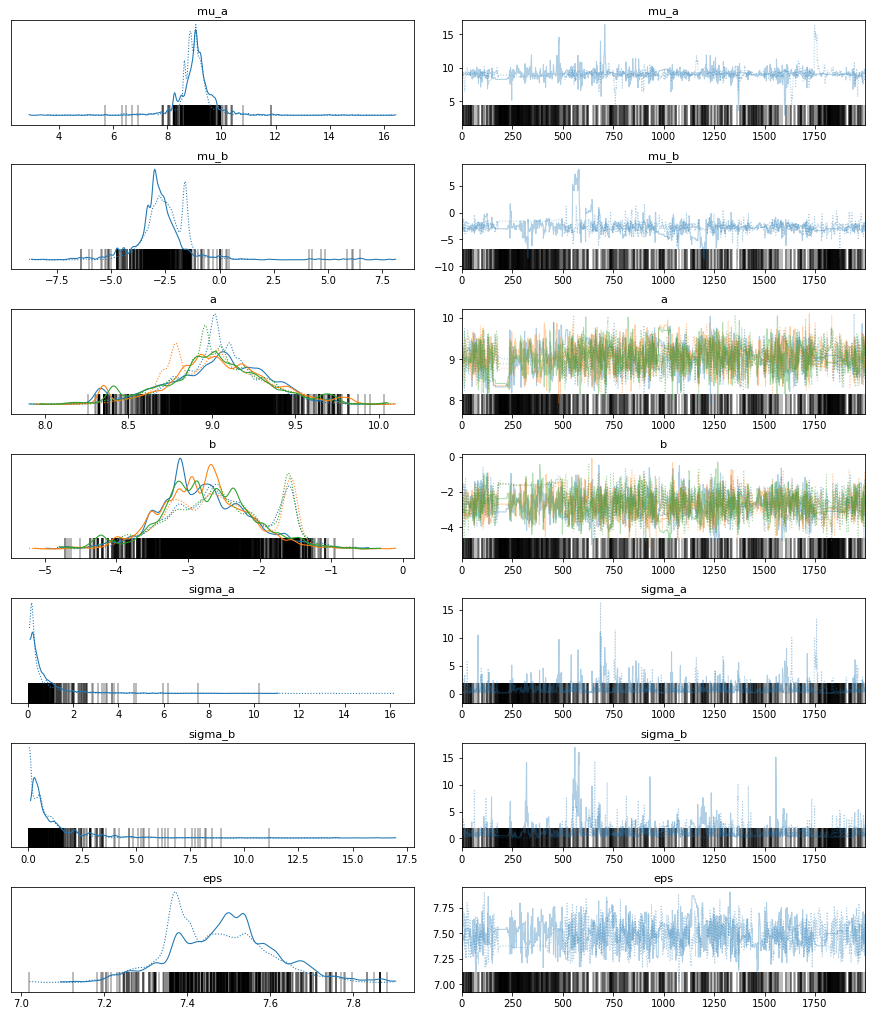

In [39]:
pm.traceplot(hierarchical_trace);